In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import pyfolio as pf
import scipy.optimize as sco

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
n_assets = len(RISKY_ASSETS)

In [3]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')
N_DAYS=len(prices_df)

[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


In [21]:
returns_df

,AAPL,IBM,MSFT
Date,,,
2018-01-03,-0.000174,0.027488,0.004654
2018-01-04,0.004645,0.020254,0.008801
2018-01-05,0.011385,0.004886,0.012398
2018-01-08,-0.003714,0.006031,0.001020
2018-01-09,-0.000115,0.002202,-0.000680
...,...,...,...
2018-12-21,-0.038896,-0.018404,-0.032312
2018-12-24,-0.025874,-0.030376,-0.041739
2018-12-26,0.070421,0.035511,0.068310


In [4]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [5]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate): 
    portf_returns = np.sum(avg_rtns * w) 
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility 
    return -portf_sharpe_ratio 
def port_vol(w, avg_rtns, cov_mat, rf_rate): 
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    return portf_volatility

In [22]:
initial_guess

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

In [6]:
n_assets = len(avg_returns) 
RF_RATE = 0 

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq', 
                'fun': lambda x: np.sum(x)-1})
bounds = tuple((0,1) for asset in range(n_assets)) 
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args, 
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)
min_vol_portf = sco.minimize(port_vol, 
                                x0=initial_guess, 
                                args=args, 
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)

In [27]:
max_sharpe_portf

     fun: -0.7537880544969541
     jac: array([6.83071390e-01, 1.22896638e+00, 7.45058060e-09])
 message: 'Optimization terminated successfully'
    nfev: 8
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.00000000e+00, 3.33066907e-16, 1.00000000e+00])

In [26]:
min_vol_portf.x.sum()

1.0

In [9]:
import scipy
import scipy.linalg

In [10]:
T = 1
N= len(returns_df)
N_SIM=10**3

In [11]:
# returns_df = prices_df['Adj Close'].pct_change().dropna()
# avg_returns = returns_df.mean() * N_DAYS
# cov_mat = returns_df.cov() * N_DAYS

In [12]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    np.random.seed(random_seed)

    dt = T/N 
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis =1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

In [13]:
shares=min_vol_portf.x

In [14]:
mu=np.matmul(avg_returns,shares)
sigma = np.matmul(np.matmul(shares,cov_mat.values),shares.T)

In [15]:
gbm_simulations = simulate_gbm(1, mu, sigma, N_SIM, T, N)

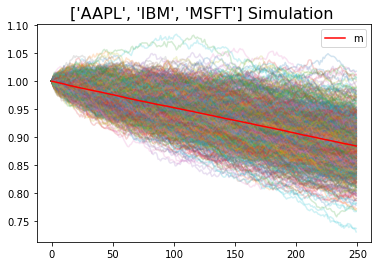

In [16]:
# prepare objects for plotting 
# last_train_date = train.index[-1].date()
# first_test_date = test.index[0].date()
# last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSETS} Simulation ')

# selected_indices = adj_close[last_train_date:last_test_date].index
# index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations))

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot( gbm_simulations_df.mean(axis=1), 
                  color='red')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1,), ('mean'))


#plt.savefig('images/ch6_im2.png')


In [17]:
shares=max_sharpe_portf.x

In [18]:
mu=np.matmul(avg_returns,shares)
sigma = np.matmul(np.matmul(shares,cov_mat.values),shares.T)

In [19]:
gbm_simulations = simulate_gbm(1, mu, sigma, N_SIM, T, N)

NameError: name 'plt' is not defined

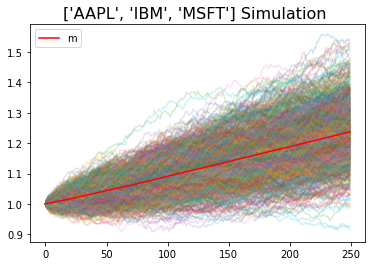

In [20]:
# prepare objects for plotting 
# last_train_date = train.index[-1].date()
# first_test_date = test.index[0].date()
# last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSETS} Simulation ')

# selected_indices = adj_close[last_train_date:last_test_date].index
# index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations))

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot( gbm_simulations_df.mean(axis=1), 
                  color='red')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1,), ('mean'))

plt.tight_layout()
#plt.savefig('images/ch6_im2.png')
plt.show()